<a href="https://colab.research.google.com/github/bibekpaudyal1/Clustering_FLearning_VNetwork_Project/blob/main/federated_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow


In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Parse the XML data
tree = ET.parse('emissionOut.xml')
root = tree.getroot()

# Define lists to store data
data = {
    'time': [],
    'id': [],
    'eclass': [],
    'CO2': [],
    'CO': [],
    'HC': [],
    'NOx': [],
    'PMx': [],
    'fuel': [],
    'electricity': [],
    'noise': [],
    'route': [],
    'type': [],
    'waiting': [],
    'lane': [],
    'pos': [],
    'speed': [],
    'angle': [],
    'x': [],
    'y': []
}

# Extract data from XML and populate lists
for timestep in root:
    time = timestep.attrib['time']
    for vehicle in timestep:
        data['time'].append(time)
        data['id'].append(vehicle.attrib['id'])
        data['eclass'].append(vehicle.attrib['eclass'])
        data['CO2'].append(float(vehicle.attrib['CO2']))
        data['CO'].append(float(vehicle.attrib['CO']))
        data['HC'].append(float(vehicle.attrib['HC']))
        data['NOx'].append(float(vehicle.attrib['NOx']))
        data['PMx'].append(float(vehicle.attrib['PMx']))
        data['fuel'].append(float(vehicle.attrib['fuel']))
        data['electricity'].append(float(vehicle.attrib['electricity']))
        data['noise'].append(float(vehicle.attrib['noise']))
        data['route'].append(vehicle.attrib['route'])
        data['type'].append(vehicle.attrib['type'])
        data['waiting'].append(float(vehicle.attrib['waiting']))
        data['lane'].append(vehicle.attrib['lane'])
        data['pos'].append(float(vehicle.attrib['pos']))
        data['speed'].append(float(vehicle.attrib['speed']))
        data['angle'].append(float(vehicle.attrib['angle']))
        data['x'].append(float(vehicle.attrib['x']))
        data['y'].append(float(vehicle.attrib['y']))

df = pd.DataFrame(data)

df.dropna(inplace=True)

# Feature selection
selected_features = ['CO2', 'CO', 'HC', 'NOx', 'PMx','speed']
X = df[selected_features]
#target
y = df['fuel']


scalerX = StandardScaler()
X_scaled = scalerX.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



def federated_learning(subset_X, subset_y):
    model = xgb.XGBRegressor()
    model.fit(subset_X, subset_y)
    return model


subset_size = len(x_train) // 3
federated_models = []
for i in range(0, len(x_train), subset_size):
    subset_X = x_train[i:i+subset_size]
    subset_y = y_train[i:i+subset_size]
    model = federated_learning(subset_X, subset_y)
    federated_models.append(model)

# Evaluate each federated model
print("RMSE of federated models:")
rmse_scores = []
for idx, model in enumerate(federated_models):
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    rmse_scores.append(rmse)
    print(f"Model {idx + 1}: {rmse}")

# Calculate average RMSE of federated models
avg_rmse_federated = np.mean(rmse_scores)

# Train a global model on the whole dataset
global_model = xgb.XGBRegressor()
global_model.fit(x_train, y_train)
y_pred_global = global_model.predict(x_test)
mse_global = mean_squared_error(y_test, y_pred_global)
rmse_global = np.sqrt(mse_global)

print("\nAverage RMSE of federated models:", avg_rmse_federated)
print("RMSE of the global model:", rmse_global)


RMSE of federated models:
Model 1: 31.45577266001291
Model 2: 18.244440219391787
Model 3: 23.47979683879943
Model 4: 659.8860493294914

Average RMSE of federated models: 183.26651476192387
RMSE of the global model: 23.46016774998053


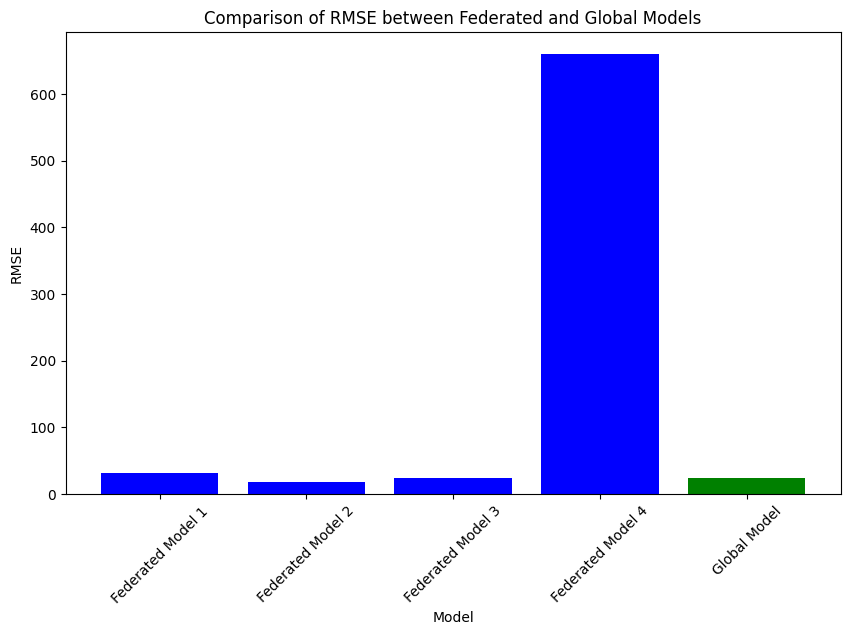

In [ ]:
import matplotlib.pyplot as plt

model_labels = [f"Federated Model {idx + 1}" for idx in range(len(federated_models))]
model_labels.append("Global Model")

rmse_values = rmse_scores + [rmse_global]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(model_labels, rmse_values, color=['blue'] * len(federated_models) + ['green'])
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE between Federated and Global Models')
plt.xticks(rotation=45)
plt.show()
